In [121]:
import numpy as np
import pandas as pd
import math
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import io
import requests
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from  matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler  

In [122]:
#Se lee la información desde la url
url="http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
s=requests.get(url).content

#Se definen las variables target y features
target = ['mpg']
features = [ 'cylinders',
'displacement',
'horsepower',
'weight',
'acceleration',
'model year',
'origin',
'car name']
input_columns = target + features

#Se carga el dataset leído desde la url en un dataframe
data = pd.read_csv(io.StringIO(s.decode('utf-8')),delim_whitespace=True,names=input_columns)
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [123]:
print(f'Number of features {data.shape[1]-1}\nNumber of Data Points {data.shape[0]}')
missing_data_points =(data == '?').astype(int).sum()
print(f'\nThe number of missing data points per feature\n\n{missing_data_points}')

Number of features 8
Number of Data Points 398

The number of missing data points per feature

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64


In [124]:
data['car name'] = LabelEncoder().fit_transform(data['car name'])
data=data.replace('?', np.nan).ffill()

car_train, car_test, tar_train, tar_test = train_test_split(data[features], data[target],test_size = 0.25,random_state=2)
car_test, validation, tar_test, target_validation = train_test_split(car_test, tar_test,test_size = 0.5,random_state=2)

# Convert targets to 1d array in order to remove warnings
tar_train = tar_train.values.ravel()
tar_test = tar_test.values.ravel()
target_validation = target_validation.values.ravel()

print(f'Using {car_train.shape[0]} Data points for training, {car_test.shape[0]} for testing and {target_validation.shape[0]} for validation ...')

Using 298 Data points for training, 50 for testing and 50 for validation ...


In [95]:
#Para buscar la configuración más óptima, 
#Definimos dos posibles tipos de kernel. Un kernel radial y otro lineal
kernels=['rbf','linear']
#Definimos varios valores de C, que determinan el tamaño del softmargin, para probar cuál de ellos es más óptimo
cs=[0.001, 0.10, 0.1, 1, 10]
#Definimos varios valores de gamma, que determinan el radio de influencia de cada punto
gammas=[0.001, 0.01, 0.1, 1]

#Inicializamos las variables que guardarán los mejores valores encontrados
maxscore=-100
maxkernel=''
maxcs=0
maxgamma=0
mse = 0
mse = 0
mae = 0
#rmlse=0
prediction=0
best_SVM = None

#Vamos recorriendo todas las posibles configuraciones de kernel, C y gamma
for i in kernels:
    for j in cs:
        for k in gammas:
            #Creamos un nuevo modelo
            model=svm.SVR(kernel=i,C=j, gamma=k)
            #Entrenamos el modelo
            model.fit(car_train, tar_train) 
            #Obtenemos los valores de predicción, score, MSE y MAE
            pred   = model.predict(car_test)
            scor   = model.score(car_test, tar_test)
            mse_   = mean_squared_error(tar_test,pred)
            mae_   = mean_absolute_error(tar_test,pred)
            #rmlse_ = mean_squared_log_error(tar_test,pred)
            
            #Si el score es mayor que el máximo score obtenido hasta el momento,
            #guardamos este modelo como el mejor, almacenando todos sus valores 
            #de configuración y métricas.
            if(scor>maxscore):
                maxscore=scor
                maxkernel=i
                maxcs=j
                maxgamma=k
                mse   = mse_
                mae   = mae_
                #rmlse = rmlse_
                prediction = pred
                best_SVM = model
                
print("Se ha conseguido un score de "+
      str(maxscore)+" utilizando los parámetros: C: "+str(maxcs)+", Kernel: "+maxkernel+", Gamma: "+str(maxgamma)) 
print("Error cuadrático medio (MSE): "+str(mse))
print("Error absoluto medio (MAE): "+str(mae))
print("Raíz del error cuadrático medio (RMSE): "+str(math.sqrt(mse)))
#print("Logaritmo de la raíz del error cuadrático medio (RMLSE): "+str(smlse))



Se ha conseguido un score de 0.8345560117732478 utilizando los parámetros: C: 1, Kernel: linear, Gamma: 0.001
Error cuadrático medio (MSE): 10.638848530107234
Error absoluto medio (MAE): 2.5145364278111817
Raíz del error cuadrático medio (RMSE): 3.261724778412065


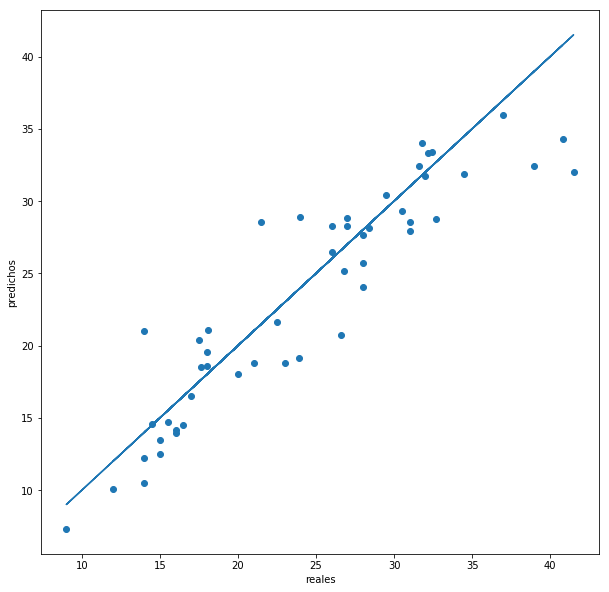

In [99]:
pyplot.figure(figsize=(10,10))
pyplot.scatter(tar_test,prediction)
pyplot.plot(tar_test, tar_test)
pyplot.xlabel('reales')
pyplot.ylabel('predichos')
pyplot.show()

Se aprecia una pérdida de precisión a partir de 38 mpg. El modelo subestima los valores.

### Red neuronal

In [125]:
#El siguiente código es para normalizar los datos
scaler = StandardScaler()  
scaler.fit(car_train)  
training_features = scaler.transform(car_train)  
test_features = scaler.transform(car_test)
scaled_validation = scaler.transform(validation)
training_targets = tar_train
test_targets = tar_test

In [126]:
# Define some helper functions
def train_NN(training_features, training_targets, model, model_kwargs, seed):
    # Build a model of given type and arguments
    modelNN = model(**model_kwargs, random_state=seed)

    # Train it
    modelNN.fit(training_features, training_targets)
    
    return modelNN

def NN_testbed(training_features, training_targets, test_features, test_targets, model, model_kwargs, seed=42):
    # Train a NN on given training data using the given model arguments
    # Return its accuracy and mse on the test data
    
    modelNN = train_NN(training_features, training_targets, model, model_kwargs, seed)
    
    # Calculate its score on the test data
    pred = modelNN.predict(test_features)
    
    score = modelNN.score(test_features, test_targets)
    mse = mean_squared_error(test_targets, pred)
    
    return score, mse

def generate_all_configurations(config):
    # Use given dictionary to generate all possible permutations of configs
    complete_configs = []
    template = {}

    # Start out with one template config
    complete_configs.append({})

    # Add a new config for each possible parameter and value tuple
    for param, values in config.items():
        current_configs = complete_configs.copy()
        complete_configs = [] # Make sure to discard the old ones, not containing a latest parameter

        for new_config in current_configs.copy():
                for value in values:
                    new_config.update({param: value})
                    complete_configs.append(new_config.copy())

    return complete_configs




In [127]:
# Generate a set of hyper paremeters to test
configurations = {'hidden_layer_sizes': [(10, ), (50,), (100,), (10, 10,), (50, 50, )],
                  'activation': ['relu', 'identity'],
                  'alpha': [0.0001, 0.01, 0.10,],
                  'batch_size': ['auto', ],
                  'learning_rate_init': [0.1, 0.01, 0.001],
                  'max_iter': [1000, ],
                 }

test_configs = generate_all_configurations(configurations)
print(f'Generated {len(test_configs)} different configurations to test ...')

Generated 90 different configurations to test ...


In [128]:
# Find the parameter setting that produces the highest r2 score

best_score = -1000
best_mse = 0
best_config = {}

for i, config in enumerate(test_configs):
    score, mse = NN_testbed(training_features, training_targets, test_features, test_targets, MLPRegressor, config)
    print(f'config {i} gives a score of {score}')
    
    if score > best_score:
        best_score = score
        best_mse = mse
        best_config = config
    
print(f'\n\nFound the best config to be:\n{best_config}\n with a score of {best_score}, and mse {best_mse}')

config 0 gives a score of 0.1808991178440802
config 1 gives a score of 0.8047999973658045


/Users/manuel.pasieka/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


config 2 gives a score of 0.5872333739258879
config 3 gives a score of 0.1809170699294128
config 4 gives a score of 0.8047682536086084
config 5 gives a score of 0.5872427298946787
config 6 gives a score of 0.18108021269644903
config 7 gives a score of 0.8050357469180737
config 8 gives a score of 0.5871981702942569
config 9 gives a score of 0.38566879089060707
config 10 gives a score of 0.8557343031350372
config 11 gives a score of 0.8459818394754482
config 12 gives a score of 0.38570102472457835
config 13 gives a score of 0.8557345750284633
config 14 gives a score of 0.8459815409629698
config 15 gives a score of 0.38599396123508833
config 16 gives a score of 0.8557370249333792
config 17 gives a score of 0.8459787996565362
config 18 gives a score of 0.8448943538311792
config 19 gives a score of 0.8568093327374123
config 20 gives a score of 0.8544144805268252
config 21 gives a score of 0.8565025629853963
config 22 gives a score of 0.8567263112579386
config 23 gives a score of 0.854412420

Best NN has a score of 0.8744126422256435 with a mse 8.075874445353318


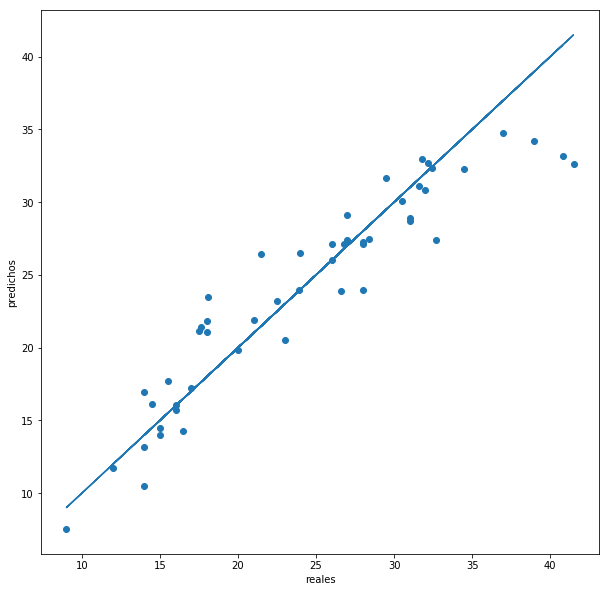

In [118]:
best_NN = train_NN(training_features, training_targets, MLPRegressor, best_config, 42)

prediction = best_NN.predict(test_features)
score = best_NN.score(test_features, test_targets)
mse = mean_squared_error(test_targets, prediction)

print(f'Best NN has a score of {score} with a mse {mse}')

pyplot.figure(figsize=(10,10))
pyplot.scatter(test_targets,prediction)
pyplot.plot(test_targets, test_targets)
pyplot.xlabel('Truth')
pyplot.ylabel('Prediction')
pyplot.show()

SVM 0.8787425432847087 with a mse 7.4140223645710215
NN 0.8713039428732952 with a mse 7.868839340823606


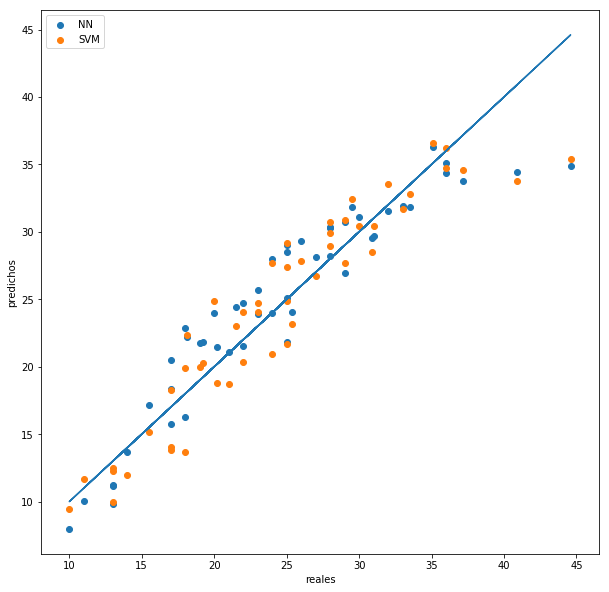

In [120]:
# Compare the two models using the validation data
svm_prediction   = best_SVM.predict(validation) 
svm_score   = best_SVM.score(validation, target_validation)
svm_mse   = mean_squared_error(target_validation, svm_prediction)

NN_prediction   = best_NN.predict(scaled_validation) 
NN_score   = best_NN.score(scaled_validation, target_validation)
NN_mse   = mean_squared_error(target_validation, NN_prediction)

print(f'SVM {svm_score} with a mse {svm_mse}')
print(f'NN {NN_score} with a mse {NN_mse}')

pyplot.figure(figsize=(10,10))
pyplot.scatter(target_validation,NN_prediction, label='NN')
pyplot.scatter(target_validation,svm_prediction, label='SVM')
pyplot.plot(target_validation, target_validation)
pyplot.xlabel('Truth')
pyplot.ylabel('Prediction')
pyplot.legend()
pyplot.show()

In [36]:
# Set the parameters by cross-validation
tuned_parameters = [{'hidden_layer_sizes': [(10, ), (50,), (100,), (10, 10,), (50, 50, )],
                  'activation': ['relu', 'identity'],
                  'alpha': [0.0001, 0.01, 0.10, 0.2],
                  'learning_rate_init': [0.1, 0.01, 0.001],
                    'max_iter': [1000, ],}]

clf = GridSearchCV(MLPRegressor(random_state=45), tuned_parameters, cv=5, n_jobs=-1)
clf.fit(data[features], data[target].values.ravel())

print(f'Best score {clf.best_score_} achieved with the parameters {clf.best_params_}')

Best score -0.5753095333122491 achieved with the parameters {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.1, 'max_iter': 1000}
